# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE eGeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_egemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_all_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_egemaps_features = df_essentia_all_opensmile_egemaps_features[df_essentia_all_opensmile_egemaps_features.columns[1:]]

df_essentia_all_opensmile_egemaps_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,2,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,3,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,4,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,5,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,7,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,1997,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,1998,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,1999,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [4]:
df_essentia_all_opensmile_egemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 4602 columns):
 #     Column                                           Dtype  
---    ------                                           -----  
 0     song_id                                          int64  
 1     lowlevel.average_loudness                        float64
 2     lowlevel.barkbands_crest.dmean                   float64
 3     lowlevel.barkbands_crest.dmean2                  float64
 4     lowlevel.barkbands_crest.dvar                    float64
 5     lowlevel.barkbands_crest.dvar2                   float64
 6     lowlevel.barkbands_crest.max                     float64
 7     lowlevel.barkbands_crest.mean                    float64
 8     lowlevel.barkbands_crest.median                  float64
 9     lowlevel.barkbands_crest.min                     float64
 10    lowlevel.barkbands_crest.stdev                   float64
 11    lowlevel.barkbands_crest.var                     flo

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_egemaps_whole = pd.merge(df_essentia_all_opensmile_egemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_egemaps_whole = df_essentia_all_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_egemaps_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429,-0.475,-0.500
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348,-0.375,-0.425
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370,0.175,0.125
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132,-0.150,0.075
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006,-0.275,0.225
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482,0.075,-0.275
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258,0.350,0.300
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_egemaps_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 300

Define the neural network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [13]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 4601])


Training loop

In [14]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [15]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.563541005381574
Epoch 2, Loss: 0.5608623826248755
Epoch 3, Loss: 0.5588380772768228
Epoch 4, Loss: 0.5573479692295661
Epoch 5, Loss: 0.5564309779443404
Epoch 6, Loss: 0.556119413799234
Epoch 7, Loss: 0.5563390349807732
Epoch 8, Loss: 0.5565962924369121
Epoch 9, Loss: 0.5565224773103902
Epoch 10, Loss: 0.5562847137334764
Epoch 11, Loss: 0.5557612382762376
Epoch 12, Loss: 0.5549359638198434
Epoch 13, Loss: 0.553676570518782
Epoch 14, Loss: 0.5516221681475049
Epoch 15, Loss: 0.5483288920965702
Epoch 16, Loss: 0.5430570571772418
Epoch 17, Loss: 0.5352744647140574
Epoch 18, Loss: 0.5256012845217455
Epoch 19, Loss: 0.5185569001633731
Epoch 20, Loss: 0.5192233729379102
Epoch 21, Loss: 0.5250603584379375
Epoch 22, Loss: 0.5162756311736494
Epoch 23, Loss: 0.5156437263556177
Epoch 24, Loss: 0.5052630175329681
Epoch 25, Loss: 0.5058675345569155
Epoch 26, Loss: 0.5028517875709406
Epoch 27, Loss: 0.501453046650655
Epoch 28, Loss: 0.5020477265148356
Epoch 29, Loss: 0.496529335369284

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [16]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 4601])


Generating scores

In [17]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [18]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.22096698976738818
Test R^2 score: 0.4690824210306709


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 2.4564e-01,  2.9180e-01],
        [-3.0136e-01, -3.7426e-01],
        [ 4.4432e-01,  4.0740e-01],
        [ 1.1336e-01,  1.5548e-01],
        [-1.0340e-01, -1.5566e-01],
        [-2.6345e-01, -3.0734e-01],
        [-3.7583e-01, -4.9635e-01],
        [ 3.7838e-01,  3.5355e-01],
        [-4.0432e-01, -5.3780e-01],
        [ 4.3610e-01,  3.9867e-01],
        [-4.9650e-02, -9.9834e-02],
        [-7.7535e-02, -1.3164e-01],
        [-2.9802e-01, -3.6827e-01],
        [ 2.7670e-01,  3.0521e-01],
        [-1.6542e-01, -2.1199e-01],
        [-1.5632e-02, -5.1602e-02],
        [-3.2006e-01, -4.0787e-01],
        [-1.3739e-01, -1.8669e-01],
        [ 1.3512e-01,  1.9136e-01],
        [-3.3123e-01, -4.2791e-01],
        [-5.3421e-01, -7.2699e-01],
        [-3.6025e-01, -4.7370e-01],
        [-3.1477e-01, -3.9837e-01],
        [ 1.8458e-01,  2.6009e-01],
        [ 1.3999e-01,  1.9980e-01],
        [ 1.6372e-01,  2.3843e-01],
        [ 4.4883e-01,  4.1217e-01],
        [-2.1676e-02, -6.034

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5587635449126782
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30483553208018677
Test R^2 score: -0.011635226531453102
Num of epochs: 2
Epoch 1, Loss: 0.5575169140768839
Epoch 2, Loss: 0.5562630962587478
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30339028437088683
Test R^2 score: -0.002965888709792419
Num of epochs: 3
Epoch 1, Loss: 0.5685167127616932
Epoch 2, Loss: 0.5644673276388193
Epoch 3, Loss: 0.5615970994483186
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30861525847187626
Test R^2 score: -0.03455593179042271
Num of epochs: 4
Epoch 1, Loss: 0.5570446756465072
Epoch 2, Loss: 0.556375380112041
Epoch 3, Loss: 0.556183985746945
Epoch 4, Loss: 0.5562631498346926
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3032371913853048
Test R^2 score: -0.002442775703987432
Num of epochs: 5
Epoch 1, Loss: 0.5604990762674035
Epoch 2, Loss: 0.5580368734075225
Epoch 3

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.011635226531453102,
 -0.002965888709792419,
 -0.03455593179042271,
 -0.002442775703987432,
 0.0006567850294083022,
 0.0019037486664332248,
 0.0025979158338881314,
 -0.0034769257558262545,
 0.007735229794417653,
 0.011108494929582935,
 0.0012151158093174352,
 0.008518542511713467,
 0.08274451781496561,
 0.02132120760824996,
 0.28347422161838515,
 0.08792623227280388,
 0.2252287442857318,
 0.16172825197258084,
 0.2991833890441022,
 0.3022370775006315,
 0.3812870429405996,
 0.342924636820429,
 0.26637626073886145,
 0.3520556553323958,
 0.3753904500262179,
 0.39790151124600776,
 0.2526263154813366,
 0.4093220176054743,
 0.3481512016761946,
 0.282623909270674,
 0.360097875182067,
 0.40677183218049523,
 0.4030944032106898,
 0.4400330081777802,
 0.39266911681837036,
 0.40346739096196754,
 0.40388387435125267,
 0.34390784991265066,
 0.45051182165515274,
 0.38219512542019085,
 0.4762683284937416,
 0.42998384956653746,
 0.42214791748536995,
 0.4592009774440146,
 0.4349558974882799,
 0.465585

Plot the line graph

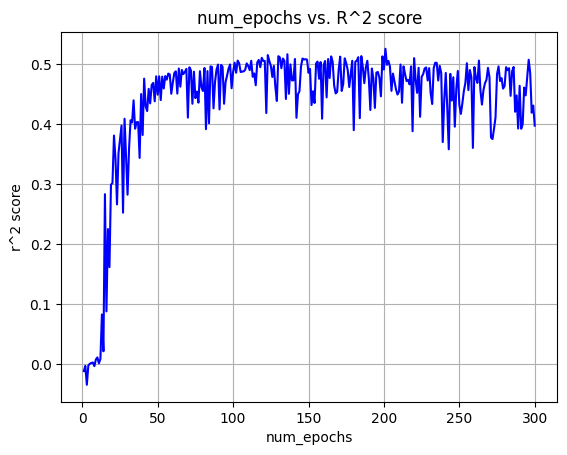

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5260590565764187
Corresponding RMSE: 0.20879351015668074
Corresponding num_epochs: 201
